In [1]:
import requests
import json
from pymongo import MongoClient
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer, MWETokenizer
from nltk.util import ngrams
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.corpus import stopwords, wordnet, words
set(stopwords.words('english'))

from sklearn.preprocessing import scale, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
my_words = ['wa','ha','aa','don','ve','got','burger','sushi','rice','taco','salad','sandwich','mexican',
            'chinese','tortilla','bean','shrimp','mahi','pizza','burrito','pork','fish','sauce','potato',
            'fried','hibachi','breakfast','wine','beer','lunch','dinner','rib','pulled','drink','chicken',
            'thai','guacamole','onion','pie','garlic','chip','salsa','brisket','spring roll','roll','tuna',
            'buffet','tot','bacon','cheese','mac','meat','soup','curry','italian','indian','wing','charlotte',
            'restaurant','just','really','little','thing','think','didn','make','know','ok','way','lot',
            'want','star','say','wasn','place','came','tried','eaten','bq','bit','try','couple','highly',
            'looking','pretty','went','year','week','twice','did','bar','area','going','fry','food','dish',
            'steak','cooked','eat','visited','fast food','definitely','coffee','brunch','egg','biscuit',
            'waffle','grit','toast','sunday','french','bagel','french toast','pancake','spot','morning',
            'sunday brunch','sausage','benedict','mimosa','hash','super','absolutely','definitely','really',
            'worth', 'come','cake','dessert','beef','new','meal','bread','green','item','plate','special',
            'day', 'veggie', 'bowl','option','portion',
            'recommend','wonderful','amazing','loved','bad','good','nice','great','love','best','like','better',
            'excellent','terrible']
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_words)

from gensim import corpora, models, similarities, matutils, utils
import gensim

import spacy
nlp = spacy.load('en_core_web_lg')

import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import warnings
warnings.filterwarnings('ignore')

### Import Data FROM MongoDB

In [2]:
# Connect to Mongo database 'Yelp' on AWS.
config = {
  'host': '3.130.17.136:27017',
  'username': 'mongo_user',
  'password': 'pW1502@',
  'authSource': 'yelp'
}

client = MongoClient(**config)

db = client.yelp

In [3]:
# Show all the collections in 'Yelp' database.
db.list_collection_names()

['review', 'business']

In [4]:
# Show first document of collection 'business'.
business_cs = db.business.find().limit(1)
list(business_cs)

[{'_id': ObjectId('5d520dc2df3c44719f5ffa57'),
  'business_id': '1SWheh84yJXfytovILXOAQ',
  'name': 'Arizona Biltmore Golf Club',
  'address': '2818 E Camino Acequia Drive',
  'city': 'Phoenix',
  'state': 'AZ',
  'postal_code': '85016',
  'latitude': 33.5221425,
  'longitude': -112.0184807,
  'stars': 3.0,
  'review_count': 5,
  'is_open': 0,
  'attributes': {'GoodForKids': 'False'},
  'categories': 'Golf, Active Life',
  'hours': None}]

In [5]:
# Show first two documents of collection 'review'.
review_cs = db.review.find().limit(2)
list(review_cs)

[{'_id': ObjectId('5d5309a1df3c44719f62f41c'),
  'review_id': 'Q1sbwvVQXV2734tPgoKj4Q',
  'user_id': 'hG7b0MtEbXx5QzbzE6C_VA',
  'business_id': 'ujmEBvifdJM6h6RLv4wQIg',
  'stars': 1.0,
  'useful': 6,
  'funny': 1,
  'cool': 0,
  'text': 'Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.',
  'date': '2013-05-07 04:34:36'},
 {'_id': ObjectId('5d5309a1df3c44719f62f41d'),
  'review_id': 'GJXCdrto3ASJOqKeVWPi6Q',
  'user_id': 'yXQM5uF2jS6es16SJzNHfg',
  'business_id': 'NZnhc2sEQy3RmzKTZnqtwQ',
  'stars': 5.0,
  'useful': 0,
  'funny': 0,
  'cool': 0,
  'text': "I *adore* Travis at the Hard Rock's new Kelly Cardenas Salon!  I'm always a fan of a great blowout and no stranger to the chains that offer this service; however, Travis has taken the flawless blowout to a whole new level!  \n\nTravis's greets you with his perfectly green swoosh i

### Restaurants in Charlotte NC

In [6]:
# This function is used to return documents that show pattern defined by user, i.e. return business 
# categories that contain the word 'restaurant'.
def get_pattern_query(pattern,starting_with=False,ending_with=False,ignore_case=False):
    start = '^' if starting_with else '.*'
    end = '$' if ending_with else '.*'
    pattern = start + re.escape(pattern) + end
    return re.compile(pattern, re.IGNORECASE) if ignore_case else re.compile(pattern)

In [7]:
# Show the number of restaurants in North Carolinas.
db.business.find({'state':'NC','categories':get_pattern_query('restaurant',ignore_case=True)}).count()

4327

In [8]:
# Obtain all business in Charlotte, NC that are tagged as Restaurant.
charlotte_rest = list(db.business.find({'state':'NC','city':get_pattern_query('charlotte',ignore_case=True),
                                        'categories':get_pattern_query('restaurant',ignore_case=True)},
                                       {'_id':0,'city':1,'state':1,'latitude':1,'longitude':1,'business_id':1,
                                        'name':1,'stars':1,'categories':1}))

In [9]:
# Convert the list to Pandas dataframe.
charlotte_rest_df = pd.DataFrame(charlotte_rest)

In [10]:
# Extact business ID of restaurants in Charlotte, NC.
restaurant_id_in_clt = list(charlotte_rest_df.business_id)

### Filter Review Collection using business_id in Charlotte NC

In [11]:
# Use the restaurant business ID to obtain all Yelp restaurant reviews in Chalotte, NC.
restaurant_review_charlotte = list(db.review.find({'business_id':{'$in':restaurant_id_in_clt}}))

In [12]:
# Check the number of Charlotte restaurant reviews.
len(restaurant_review_charlotte)

208631

In [13]:
# Display first two reviews.
restaurant_review_charlotte[2]

{'_id': ObjectId('5d5309a2df3c44719f62f45c'),
 'review_id': 'ASZha3MiQJghtt3n5OGIsA',
 'user_id': 'Fyn9aNWs0Qcz6T-uIJal4w',
 'business_id': 'ZCsvwa_dsqNB8d8tYHPdjw',
 'stars': 4.0,
 'useful': 0,
 'funny': 0,
 'cool': 0,
 'text': "This random hole in the wall is located in the Park Rd. shopping center.  I had never heard of it until that fateful St. Patricks day when another beer was in order.  After making my way there and enjoying the patio, I decided the food was my next venture.\n\nAfter my second, alcohol only, visit, I was excited to taste what vegetarian options they had.  I had the grilled cheese with spicy asparagus and portobello.  Let me tell you...grilled cheese is amazing, add a few interesting touches, it becomes addicting.  I was very happy with my sandwich.  Also, they have a very tasty appetizer of Goat Cheese Fritters with a red wine sauce.  Goat Cheese is one of my favorites and frying anything makes it better. I was in love.  \nTher service is great and they can acco

In [14]:
# Convert the list to Pandas dataframe.
clt_rest_review_df = pd.DataFrame(restaurant_review_charlotte)
clt_rest_review_df.columns

Index(['_id', 'business_id', 'cool', 'date', 'funny', 'review_id', 'stars',
       'text', 'useful', 'user_id'],
      dtype='object')

In [15]:
# Save dataframe into pickle to be used later. This helps to skip repeating the data import and conversion process.
with open('clt_rest_review.pickle', 'wb') as to_write:
    pickle.dump(clt_rest_review_df, to_write)

In [16]:
# Get data from pickle file.
with open('clt_rest_review.pickle','rb') as read_file:
    clt_rest_review_df = pickle.load(read_file)

### Merging Review Data and Business Data, and Filtering out old Reviews

In [17]:
# Merge review data and business data.
merged_df = pd.merge(clt_rest_review_df,charlotte_rest_df,on='business_id')

In [18]:
# Drop columns '_id','review_id' and 'stars_y'. Rename 'stars_x' to 'stars'
merged_df = merged_df.drop(columns=['_id','review_id','stars_y']).rename(columns={'stars_x':'stars'})

In [19]:
# Rearrange the columns orders.
merged_df = merged_df[['business_id','name','latitude','longitude','categories','user_id','date','stars','cool',
                       'funny','useful','text']]

In [20]:
# Change the string type of column 'date' to datetime type.
merged_df.iloc[:,6] = merged_df.iloc[:,6].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [21]:
# Only include reviews from 2009 to 2018.
merged_df = merged_df[merged_df['date']>=pd.Timestamp(2009, 1, 1)].reset_index(drop=True)
merged_df.head()

,business_id,name,latitude,longitude,categories,user_id,date,stars,cool,funny,useful,text
0,FBSWwaE6gR7KAOyG1QhakQ,Block & Grinder,35.170504,-80.806674,"Butcher, Nightlife, Food, American (New), Rest...",jsOz-dWToun2VsFcFAfGww,2015-01-03 21:11:31,5.0,0,0,0,Such a unique place & a great find. Our waitre...
1,FBSWwaE6gR7KAOyG1QhakQ,Block & Grinder,35.170504,-80.806674,"Butcher, Nightlife, Food, American (New), Rest...",OnYEKooAtI2zTRqBLLIfvA,2016-03-07 00:20:06,5.0,0,0,0,Easily entering my top 3 restaurants in Charlo...
2,FBSWwaE6gR7KAOyG1QhakQ,Block & Grinder,35.170504,-80.806674,"Butcher, Nightlife, Food, American (New), Rest...",xGFfrUDgDqdkfrd022FC8g,2016-05-07 01:11:52,4.0,0,0,1,I've been wanting to try this place for a whil...
3,FBSWwaE6gR7KAOyG1QhakQ,Block & Grinder,35.170504,-80.806674,"Butcher, Nightlife, Food, American (New), Rest...",qiz4Ri_cMSsoH3ccN19eAw,2013-03-18 19:23:27,5.0,2,2,2,Finally a place like this in Charlotte!!!!! Th...
4,FBSWwaE6gR7KAOyG1QhakQ,Block & Grinder,35.170504,-80.806674,"Butcher, Nightlife, Food, American (New), Rest...",bb19P4BMLbNk4I9PymkGMA,2014-10-11 13:22:26,5.0,0,0,0,Everything was delicious! The bone marrow was ...


### NLP Preprocessing

In [22]:
# Extrac review text from merged database.
review = merged_df.loc[:,'text']

In [23]:
# This function is used to remove repeating characters.
def remove_repeated_characters(token):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word
    return replace(token)

In [24]:
# This function is used to remove repeating character and lemmatize sentences.
def removerepeat_and_lemmatize(old_sentence):
    old_words = old_sentence.split()
    new_sentence = ''
    for i in old_words:
        if i not in my_stop_words:
            new_sentence += ' ' + WordNetLemmatizer().lemmatize(remove_repeated_characters(i))
    return new_sentence[1:]

In [25]:
# Text preprocessing steps - remove numbers, captial letters, punctuation, foreign characters & repeating characters,
# and finally lemmatization.
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
no_foreign_char = lambda x: re.sub('[^a-zA-Z0-9_]', ' ', x)
remove_repeat_and_lemmatize = lambda x: removerepeat_and_lemmatize(x)

review = review.map(alphanumeric).map(punc_lower).map(no_foreign_char).map(remove_repeat_and_lemmatize)
review.head()

0    unique waitress funny knowledgable fantastic j...
1    easily entering restaurant visit belly unreal ...
2    wanting glad finally quiet friday evening serv...
3    finally combined butcher shop casual dining up...
4    delicious bone marrow interesting appetizer gl...
Name: text, dtype: object

In [26]:
# Save dataframe into pickle to be used later. This helps to skip repeating data import & conversion, 
# and NLP preprocessing.
with open('clt_rest_review_processed.pickle', 'wb') as to_write:
    pickle.dump(review, to_write)

In [27]:
# Get data from pickle file.
with open('clt_rest_review_processed.pickle','rb') as read_file:
    review = pickle.load(read_file)

### Count Vectorizer

In [28]:
# Count Vectorizer - remove stop words and use unigram and bigram. Also drop the top 20% of frequent terms.
cv1 = CountVectorizer(stop_words=my_stop_words, ngram_range=(1,2), max_df=0.8)

review_cv1 = cv1.fit_transform(review)
review_cv1.toarray()
review_cv1.shape

(206576, 2692309)

Since the topic modeling using count vectorizer did not provide meaningful topics, count vectorizer is not used for further analysis and data processing.

### TF-IDF

In [29]:
# TF-IDF - remove stop words and use unigram and bigram. Also drop the top 20% of frequent terms.
tfidf1 = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1,2), max_df=0.8)

review_tfidf1 = tfidf1.fit_transform(review)
review_tfidf1.toarray()
review_tfidf1.shape

(206576, 2692309)

### Topic modeling functions

In [30]:
# This function display the result of topic modeling.
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### LSA

In [31]:
# Apply LSA to Review Data (CV1) for topic modeling. Number of components from 2 to 12 were attempted. 
# These combinations did not result in meaningful topics.
lsa_cv1 = TruncatedSVD(10)
review_topic_lsa_cv1 = lsa_cv1.fit_transform(review_cv1)
lsa_cv1.explained_variance_ratio_

array([0.01658057, 0.00654304, 0.00652858, 0.00569526, 0.00503505,
       0.00435134, 0.0035699 , 0.00324662, 0.00304253, 0.00290205])

In [32]:
# Convert the result of LSA using CV and 10 components to Pandas dataframe.
topic_word_lsa_cv1 = pd.DataFrame(lsa_cv1.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5",
                      "component_6","component_7","component_8","component_9","component_10"],
             columns = cv1.get_feature_names())
topic_word_lsa_cv1

,aaa,aaa aaa,aaa arrive,aaa baseball,aaa battery,aaa bought,aaa customer,aaa diamond,aaa discount,aaa hell,...,zydeco mardi,zydeco music,zydeco spread,zydeco zydeco,zye,zye bartender,zygma,zygma perogies,zymology,zymology fermentation
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0
component_3,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
component_4,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_5,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
component_6,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_7,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
component_8,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,...,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_9,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,...,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
component_10,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0


In [33]:
# Display the result of LSA using CV and 10 components 
display_topics(lsa_cv1, cv1.get_feature_names(), 10)


Topic  0
time, service, order, ordered, table, menu, minute, server, wait, delicious

Topic  1
order, time, minute, manager, asked, told, said, took, customer, waited

Topic  2
order, table, ordered, minute, said, asked, server, told, took, manager

Topic  3
order, ordered, time, menu, flavor, delicious, sweet, fresh, taste, hot

Topic  4
order, service, fresh, delicious, location, customer, friendly, price, customer service, favorite

Topic  5
ordered, service, time, husband, server, tasted, asked, appetizer, said, friend

Topic  6
menu, server, asked, time, service, said, wanted, manager, ask, told

Topic  7
said, asked, manager, customer, location, staff, told, people, review, experience

Topic  8
wait, staff, ordered, minute, menu, friendly, night, staff friendly, location, wait staff

Topic  9
table, ordered, night, price, location, people, order, parking, friend, small


In [34]:
# Apply LSA to Review Data (TFIDF1) for topic modeling. Number of components from 2 to 12 were attempted.
# These combinations did not result in meaningful topics.
lsa_tfidf1 = TruncatedSVD(10)
review_topic_lsa_tfidf1 = lsa_tfidf1.fit_transform(review_tfidf1)
lsa_tfidf1.explained_variance_ratio_

array([0.00064634, 0.00112149, 0.00094094, 0.00084359, 0.00070441,
       0.00068528, 0.00063709, 0.00058984, 0.00057832, 0.00054579])

In [35]:
# Convert the result of LSA using TFIDF and 10 components to Pandas dataframe.
topic_word_lsa_tfidf1 = pd.DataFrame(lsa_tfidf1.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5",
                      "component_6","component_7","component_8","component_9","component_10"],
             columns = tfidf1.get_feature_names())
topic_word_lsa_tfidf1

,aaa,aaa aaa,aaa arrive,aaa baseball,aaa battery,aaa bought,aaa customer,aaa diamond,aaa discount,aaa hell,...,zydeco mardi,zydeco music,zydeco spread,zydeco zydeco,zye,zye bartender,zygma,zygma perogies,zymology,zymology fermentation
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
component_3,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0
component_4,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0
component_5,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
component_6,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
component_7,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
component_8,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
component_9,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,...,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
component_10,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0


In [36]:
# Display the result of LSA using TFIDF and 10 components 
display_topics(lsa_tfidf1, tfidf1.get_feature_names(), 20)


Topic  0
service, time, order, ordered, delicious, menu, table, staff, friendly, wait, minute, server, night, price, fresh, experience, friend, location, atmosphere, people

Topic  1
friendly, staff, delicious, staff friendly, atmosphere, fresh, price, favorite, service, awesome, friendly staff, selection, fast, quick, friendly service, clean, tasty, fantastic, reasonable, menu

Topic  2
service, customer, customer service, friendly, slow, fast, minute, staff, time, friendly service, service slow, atmosphere, manager, horrible, service friendly, time service, poor, service fast, quick, rude

Topic  3
staff, friendly, staff friendly, wait, friendly staff, minute, order, wait staff, time, hour, waited, helpful, long, told, table, manager, waiting, took, clean, friendly helpful

Topic  4
time, order, fresh, fast, location, hot, pho, customer, price, quick, customer service, delivery, taste, delicious, line, ingredient, time time, drive, flavor, quality

Topic  5
time, atmosphere, wait, t

### NMF

In [37]:
# Apply NMF to Review Data (CV1) for topic modeling. Number of components from 2 to 12 were attempted. 
# These combinations did not result in meaningful topics.
nmf_model_cv1 = NMF(10)
review_topic_nmf_cv1 = nmf_model_cv1.fit_transform(review_cv1)

In [38]:
# Convert the result of NMF using CV and 10 components to Pandas dataframe.
topic_word_nmf_cv1 = pd.DataFrame(nmf_model_cv1.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5",
                      "component_6","component_7","component_8","component_9","component_10"],
             columns = cv1.get_feature_names())
topic_word_nmf_cv1

,aaa,aaa aaa,aaa arrive,aaa baseball,aaa battery,aaa bought,aaa customer,aaa diamond,aaa discount,aaa hell,...,zydeco mardi,zydeco music,zydeco spread,zydeco zydeco,zye,zye bartender,zygma,zygma perogies,zymology,zymology fermentation
component_1,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
component_2,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.001,0.0,0.0
component_3,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
component_4,0.002,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
component_5,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
component_6,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
component_7,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
component_8,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
component_9,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0
component_10,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0


In [39]:
# Display the result of NMF using CV and 10 components 
display_topics(nmf_model_cv1, cv1.get_feature_names(), 10)


Topic  0
table, night, wait, reservation, seated, party, hostess, people, waiter, group

Topic  1
delicious, flavor, fresh, sweet, taste, night, favorite, hot, right, price

Topic  2
time, long, second, time time, visit, wait, second time, long time, hour, experience

Topic  3
service, customer, customer service, slow, price, atmosphere, fast, experience, location, quality

Topic  4
order, location, took, placed, wrong, line, ready, pick, delivery, called

Topic  5
ordered, friend, husband, appetizer, tasted, waitress, entree, took, friend ordered, waiter

Topic  6
menu, price, selection, choice, small, look, offer, different, cocktail, favorite

Topic  7
minute, said, asked, told, manager, waitress, wait, took, people, waited

Topic  8
staff, friendly, location, wait, staff friendly, wait staff, atmosphere, clean, friendly staff, people

Topic  9
server, experience, check, asked, took, manager, brought, ask, attentive, appetizer


In [40]:
# Apply NMF to Review Data (TFIDF1) for topic modeling. Number of components from 2 to 12 were attempted.
# NMF with TFIDF data and 5 components result in meaningful topics.
nmf_model_tfidf1 = NMF(5)
review_topic_nmf_tfidf1 = nmf_model_tfidf1.fit_transform(review_tfidf1)

In [41]:
# Convert the result of NMF using TFIDF and 5 components to Pandas dataframe.
topic_word_nmf_tfidf1 = pd.DataFrame(nmf_model_tfidf1.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = tfidf1.get_feature_names())
topic_word_nmf_tfidf1

,aaa,aaa aaa,aaa arrive,aaa baseball,aaa battery,aaa bought,aaa customer,aaa diamond,aaa discount,aaa hell,...,zydeco mardi,zydeco music,zydeco spread,zydeco zydeco,zye,zye bartender,zygma,zygma perogies,zymology,zymology fermentation
component_1,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_3,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_4,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_5,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Display the result of NMF using TFIDF and 5 components 
display_topics(nmf_model_tfidf1, tfidf1.get_feature_names(), 20, topic_names=['Wait_Time','Taste','Service_Quality',
                                                                          'Staff_Friendliness','Cool_Factor'])


Topic: ' Wait_Time '
order, minute, table, took, asked, server, wait, said, ordered, told, manager, waitress, waited, hour, waiting, seated, people, finally, check, experience

Topic: ' Taste '
delicious, menu, fresh, ordered, flavor, price, favorite, night, sweet, taste, friend, small, hot, tasty, perfect, selection, spicy, awesome, atmosphere, right

Topic: ' Service_Quality '
service, customer, customer service, fast, slow, atmosphere, awesome, price, service slow, quick, friendly service, service fast, atmosphere service, service atmosphere, fantastic, service friendly, fast service, awesome service, delicious service, location

Topic: ' Staff_Friendliness '
staff, friendly, staff friendly, friendly staff, wait, wait staff, clean, helpful, atmosphere, attentive, delicious, fast, friendly service, friendly helpful, service friendly, quick, fresh, friendly attentive, awesome, selection

Topic: ' Cool_Factor '
time, long, time time, wait, location, second, long time, second time, tim

### Merging Result of Topic Modeling with Review Data

NMF with 5 components using TFIDF produces meaningful result. It's used for further processing such as clustering, EDA and recommender.

In [43]:
# Convert topic modeling result to Pandas dataframe.
review_topic_df = pd.DataFrame(review_topic_nmf_tfidf1, columns=['Wait_Time','Taste','Service_Quality',
                                                                 'Staff_Friendliness','Cool_Factor'])
review_topic_df.head(10)

,Wait_Time,Taste,Service_Quality,Staff_Friendliness,Cool_Factor
0,0.003765,0.003773,0.002422,0.000718,0.000000
1,0.000000,0.006026,0.000180,0.000000,0.001294
2,0.006355,0.013826,0.000000,0.000000,0.000000
3,0.000998,0.010711,0.001866,0.001623,0.001040
4,0.000000,0.009476,0.000000,0.000182,0.000000
5,0.019075,0.007384,0.001066,0.000208,0.006559
6,0.000000,0.014426,0.000072,0.001361,0.000639
7,0.000000,0.008144,0.000000,0.000000,0.000725
8,0.000000,0.016125,0.006709,0.000000,0.000000
9,0.004792,0.011060,0.004408,0.003329,0.006003


In [44]:
# Merge result of Topic Modeling with Review Data
combined_review_topic_df = pd.merge(merged_df, review_topic_df, left_index=True, right_index=True)
combined_review_topic_df.head()

,business_id,name,latitude,longitude,categories,user_id,date,stars,cool,funny,useful,text,Wait_Time,Taste,Service_Quality,Staff_Friendliness,Cool_Factor
0,FBSWwaE6gR7KAOyG1QhakQ,Block & Grinder,35.170504,-80.806674,"Butcher, Nightlife, Food, American (New), Rest...",jsOz-dWToun2VsFcFAfGww,2015-01-03 21:11:31,5.0,0,0,0,Such a unique place & a great find. Our waitre...,0.003765,0.003773,0.002422,0.000718,0.000000
1,FBSWwaE6gR7KAOyG1QhakQ,Block & Grinder,35.170504,-80.806674,"Butcher, Nightlife, Food, American (New), Rest...",OnYEKooAtI2zTRqBLLIfvA,2016-03-07 00:20:06,5.0,0,0,0,Easily entering my top 3 restaurants in Charlo...,0.000000,0.006026,0.000180,0.000000,0.001294
2,FBSWwaE6gR7KAOyG1QhakQ,Block & Grinder,35.170504,-80.806674,"Butcher, Nightlife, Food, American (New), Rest...",xGFfrUDgDqdkfrd022FC8g,2016-05-07 01:11:52,4.0,0,0,1,I've been wanting to try this place for a whil...,0.006355,0.013826,0.000000,0.000000,0.000000
3,FBSWwaE6gR7KAOyG1QhakQ,Block & Grinder,35.170504,-80.806674,"Butcher, Nightlife, Food, American (New), Rest...",qiz4Ri_cMSsoH3ccN19eAw,2013-03-18 19:23:27,5.0,2,2,2,Finally a place like this in Charlotte!!!!! Th...,0.000998,0.010711,0.001866,0.001623,0.001040
4,FBSWwaE6gR7KAOyG1QhakQ,Block & Grinder,35.170504,-80.806674,"Butcher, Nightlife, Food, American (New), Rest...",bb19P4BMLbNk4I9PymkGMA,2014-10-11 13:22:26,5.0,0,0,0,Everything was delicious! The bone marrow was ...,0.000000,0.009476,0.000000,0.000182,0.000000


In [45]:
# Save dataframe into pickle to be used later. This helps to skip repeating data import & conversion, 
# NLP preprocessing, and topic modeling.
with open('combined_review_topic.pickle', 'wb') as to_write:
    pickle.dump(combined_review_topic_df, to_write)

In [46]:
# Get data from pickle file
with open('combined_review_topic.pickle','rb') as read_file:
    combined_review_topic_df = pickle.load(read_file)

### Features Scaling

In [47]:
# Extracted review topics for feature scaling
X = combined_review_topic_df.loc[:,['Wait_Time','Taste','Service_Quality','Staff_Friendliness','Cool_Factor']]

In [48]:
# Scale the review topcs before KMeans Clustering
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X)).rename(columns={0:'Wait_Time',1:'Taste',2:'Service_Quality',3:'Staff_Friendliness',
                                                                           4:'Cool_Factor'})
X_scaled.head()

,Wait_Time,Taste,Service_Quality,Staff_Friendliness,Cool_Factor
0,-0.156269,-0.844956,-0.272766,-0.329489,-0.580754
1,-0.714882,-0.419313,-0.565726,-0.428164,-0.418077
2,0.228092,1.054145,-0.589264,-0.428164,-0.580754
3,-0.566785,0.465734,-0.345413,-0.204987,-0.450064
4,-0.714882,0.232323,-0.589264,-0.403150,-0.580754


### KMeans Clustering

In [49]:
# Run KMeans with number of clusters from 1 to 10 and collect the inertia in a list
inertia = []
k_vals = list(range(1,11))
for k in k_vals:
    km = KMeans(n_clusters=k, random_state=77)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

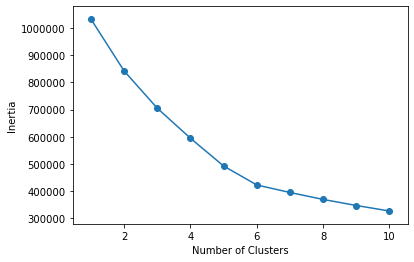

In [50]:
# Plot the inertia value vs the number of clusters. Use the elbow of the curve to pick the best number of cluster.
# It looks like clusterof six is the elbow
plt.plot(k_vals,inertia)
plt.scatter(k_vals,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [51]:
# Fix the data to KMeans with 6 clusters
km6 = KMeans(n_clusters=6, random_state=77)
km6.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=77, tol=0.0001, verbose=0)

In [52]:
# Combine cluster result with review topics
km6_cluster_df = pd.DataFrame(km6.labels_)
km6_cluster_df = pd.merge(km6_cluster_df,X_scaled,left_index=True, right_index=True).rename(columns={0:'Cluster'})
km6_cluster_df.head()

,Cluster,Wait_Time,Taste,Service_Quality,Staff_Friendliness,Cool_Factor
0,1,-0.156269,-0.844956,-0.272766,-0.329489,-0.580754
1,1,-0.714882,-0.419313,-0.565726,-0.428164,-0.418077
2,5,0.228092,1.054145,-0.589264,-0.428164,-0.580754
3,1,-0.566785,0.465734,-0.345413,-0.204987,-0.450064
4,1,-0.714882,0.232323,-0.589264,-0.403150,-0.580754


In [53]:
# Group all the reviews by clusters and get the mean of each review topic's statistical values
km6_cluster_topic_df = km6_cluster_df.groupby('Cluster')[['Wait_Time','Taste','Service_Quality',
                                                        'Staff_Friendliness','Cool_Factor']].mean()
km6_cluster_topic_df

,Wait_Time,Taste,Service_Quality,Staff_Friendliness,Cool_Factor
Cluster,,,,,
0,-0.272445,-0.575878,1.925518,-0.079236,-0.349552
1,-0.247588,-0.286714,-0.396012,-0.218057,-0.377763
2,-0.120973,-0.427771,0.014910,-0.118145,2.168657
3,2.413477,-0.965372,0.011307,-0.229932,0.099936
4,-0.376673,-0.549572,-0.239742,3.289390,-0.183708
5,-0.272360,1.232339,-0.293035,-0.208250,-0.232604


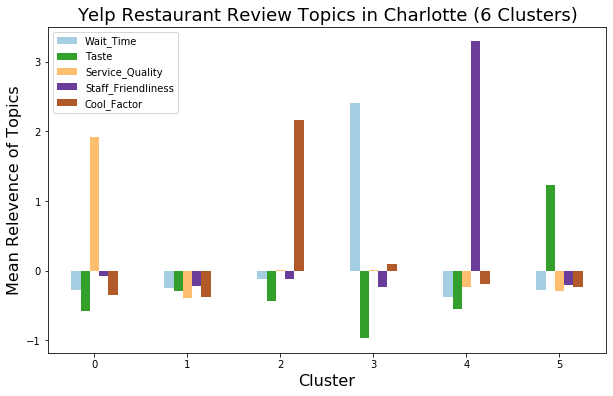

In [54]:
# Plot the results using bar plot.
km6_cluster_topic_df.plot(kind='bar', figsize=(10,6), colormap='Paired')
plt.title('Yelp Restaurant Review Topics in Charlotte (6 Clusters)', size='18')
plt.xlabel('Cluster', size='16')
plt.xticks(rotation='horizontal')
plt.ylabel('Mean Relevence of Topics', size='16');

It doesn't look like 6 clusters make sense with the 5 topics since one cluster has all topics with same ratios

In [55]:
# Fix the data to KMeans with 5 clusters
km5 = KMeans(n_clusters=5, random_state=77)
km5.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=77, tol=0.0001, verbose=0)

In [56]:
# Combine cluster result with review topics
km5_cluster_df = pd.DataFrame(km5.labels_)
km5_cluster_df = pd.merge(km5_cluster_df,X_scaled,left_index=True, right_index=True).rename(columns={0:'Cluster'})
km5_cluster_df.head()

,Cluster,Wait_Time,Taste,Service_Quality,Staff_Friendliness,Cool_Factor
0,2,-0.156269,-0.844956,-0.272766,-0.329489,-0.580754
1,2,-0.714882,-0.419313,-0.565726,-0.428164,-0.418077
2,2,0.228092,1.054145,-0.589264,-0.428164,-0.580754
3,2,-0.566785,0.465734,-0.345413,-0.204987,-0.450064
4,2,-0.714882,0.232323,-0.589264,-0.403150,-0.580754


In [57]:
# Group all the reviews by clusters and get the mean of each review topic's statistical values
km5_cluster_topic_df = km5_cluster_df.groupby('Cluster')[['Wait_Time','Taste','Service_Quality',
                                                        'Staff_Friendliness','Cool_Factor']].mean()
km5_cluster_topic_df

,Wait_Time,Taste,Service_Quality,Staff_Friendliness,Cool_Factor
Cluster,,,,,
0,-0.369126,-0.553448,-0.251373,3.136579,-0.198643
1,2.171635,-0.940273,-0.043921,-0.227004,0.039489
2,-0.294735,0.435793,-0.364469,-0.228565,-0.331682
3,-0.126231,-0.389808,-0.006286,-0.124577,2.091334
4,-0.271286,-0.565473,1.855299,-0.085766,-0.355457


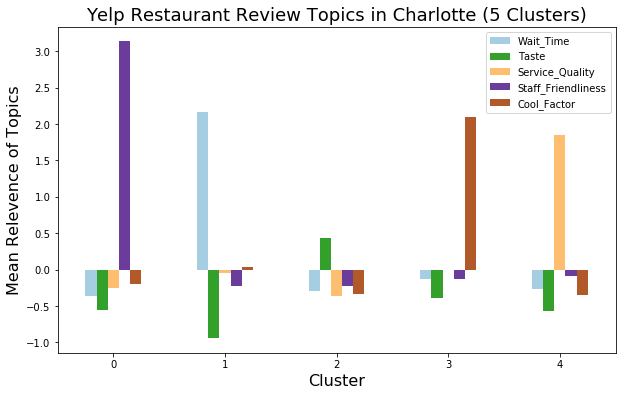

In [58]:
# Plot the results using bar plot.
km5_cluster_topic_df.plot(kind='bar', figsize=(10,6), colormap='Paired')
plt.title('Yelp Restaurant Review Topics in Charlotte (5 Clusters)', size='18')
plt.xlabel('Cluster', size='16')
plt.xticks(rotation='horizontal')
plt.ylabel('Mean Relevence of Topics', size='16');

It looks like KMeans agrees with topic modeling result. Each cluster represents one review topic.

### Major Topic Clustering

Since KMeans clustering result agrees with topic modeling result, we will assign the all reviews with the topic with highest ratio.

In [59]:
# Assign all reviews to their major topic.
X_scaled_major_topic = X_scaled.idxmax(axis=1)

### PCA

Use PCA to reduce the 5 topics to lower dimentions for plotting purposes.

In [60]:
# Use PCA to represent all information with 2 principle components.
pca = PCA(n_components=2)
pcafeatures = pca.fit_transform(X_scaled)
print('PCA Explained Variance:',pca.explained_variance_)

PCA Explained Variance: [1.45510161 1.09139566]


In [61]:
# Create a 2D scatter plot
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','y','m'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

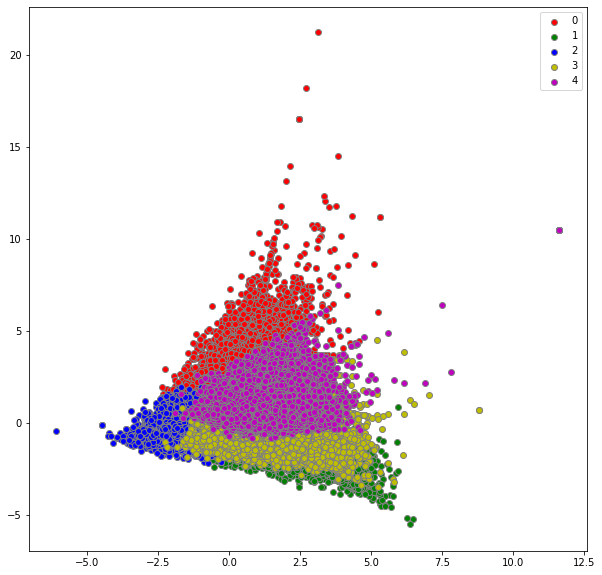

In [62]:
# 2D scatter plot with PCA results
plot_PCA_2D(pcafeatures, target=km5.labels_, target_names=[0,1,2,3,4])

In [63]:
# Use PCA to represent all information with 3 principle components.
pca3 = PCA(n_components=3)
pcafeatures3 = pca3.fit_transform(X_scaled)
print('PCA Explained Variance:',pca3.explained_variance_)

PCA Explained Variance: [1.45510161 1.09139566 0.97801767]


In [64]:
# Run Plotly examples in offline mode
init_notebook_mode(connected=True)

In [65]:
# Merge X_scaled_major_topic with pcafeatures3
major_topic_pca3_df = pd.merge(pd.DataFrame(X_scaled_major_topic).rename(columns={0:'Major_Topic'}),
          pd.DataFrame(pcafeatures3).rename(columns={0:'Component_1',1:'Component_2',2:'Component_3'}),
          left_index=True, right_index=True)
major_topic_pca3_df.head(2)

,Major_Topic,Component_1,Component_2,Component_3
0,Wait_Time,0.157012,-0.007316,0.219146
1,Cool_Factor,-0.482279,-0.023629,0.051037


In [68]:
# 3D scatter plot with PCA results using Plotly
data = []
clusters = []
colors = ['red','green','blue','goldenrod','magenta'] # set dot colors

for i in range(len(major_topic_pca3_df['Major_Topic'].unique())): # split our data into three distinct groups
    name = major_topic_pca3_df['Major_Topic'].unique()[i]
    color = colors[i]
    x = major_topic_pca3_df[ major_topic_pca3_df['Major_Topic'] == name ]['Component_1']
    y = major_topic_pca3_df[ major_topic_pca3_df['Major_Topic'] == name ]['Component_2']
    z = major_topic_pca3_df[ major_topic_pca3_df['Major_Topic'] == name ]['Component_3']
    
    trace = dict( 
        name = name,
        x = x, y = y, z = z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=3, color=color, line=dict(width=0) ) )
    data.append( trace )

layout = dict( 
    width=800*1.2,
    height=550*1.2,
    autosize=False,
    title='Yelp Charlotte Restaurant Review Topic',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Component 1',  
            titlefont=dict(
            family='Courier New',
            size=14,
            color='#2f2f2f'), 
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Component 2',  
            titlefont=dict(
            family='Courier New',
            size=14,
            color='#4f4f4f'),
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Component 3',  
            titlefont=dict(
            family='Courier New',
            size=14,
            color='#7f7f7f'),
        ),
        aspectratio = dict( x=1, y=1, z=1 ),
        aspectmode = 'manual'        
    ),
)

fig = dict(data=data, layout=layout) 

# run locally in notebook
iplot(fig)

### EDA

In [69]:
# Merge X_scaled_major_topic with combined_review_topic_df for EDA purpose.
eda_df = pd.merge(pd.DataFrame(X_scaled_major_topic).rename(columns={0:'Major_Topic'}), combined_review_topic_df, 
                  left_index=True, right_index=True)
eda_df.head(2)

,Major_Topic,business_id,name,latitude,longitude,categories,user_id,date,stars,cool,funny,useful,text,Wait_Time,Taste,Service_Quality,Staff_Friendliness,Cool_Factor
0,Wait_Time,FBSWwaE6gR7KAOyG1QhakQ,Block & Grinder,35.170504,-80.806674,"Butcher, Nightlife, Food, American (New), Rest...",jsOz-dWToun2VsFcFAfGww,2015-01-03 21:11:31,5.0,0,0,0,Such a unique place & a great find. Our waitre...,0.003765,0.003773,0.002422,0.000718,0.000000
1,Cool_Factor,FBSWwaE6gR7KAOyG1QhakQ,Block & Grinder,35.170504,-80.806674,"Butcher, Nightlife, Food, American (New), Rest...",OnYEKooAtI2zTRqBLLIfvA,2016-03-07 00:20:06,5.0,0,0,0,Easily entering my top 3 restaurants in Charlo...,0.000000,0.006026,0.000180,0.000000,0.001294


In [70]:
# Assign sentiment value using review ratings.
eda_df['Sentiment'] = eda_df['stars'].apply(lambda x: 'Positive' if x > 3 else ('Neutral' if x==3 else 'Negative'))

In [71]:
# Extract restaurant categories for further data processing.
restaurant_categories = eda_df['categories']

In [72]:
# Create a list of unique restaurant categories.
unique_rest_cate = set()
for multi in restaurant_categories:
    for single in multi.split(', '):
        unique_rest_cate.add(single)
unique_rest_cate = list(unique_rest_cate)
unique_rest_cate[0:5]

['Tours', 'Sandwiches', 'Korean', 'Reflexology', 'Coffee Roasteries']

In [73]:
# Create a restaurant filter list
restaurant_filter_list = ['Fast Food','Afghan','African','American (New)','American (Traditional)','Arabian',
                          'Argentine','Belgian','Brazilian','Breakfast & Brunch','British','Burmese',
                          'Cajun/Creole','Cantonese','Caribbean','Chicken Shop','Chinese','Colombian','Cuban',
                          'Dim Sum','Diners','Dominican','Donuts','Ethiopian','Filipino','Fish & Chips',
                          'Fondue','French','German','Greek','Haitian','Hawaiian','Himalayan/Nepalese','Honduran',
                          'Hot Dogs','Hungarian','Indian','Irish','Pizza','Italian','Izakaya','Japanese','Korean',
                          'Laotian','Latin American','Lebanese','Malaysian','Mediterranean','Mexican','Middle Eastern',
                          'Modern European','Mongolian','Moroccan','New Mexican Cuisine','Pakistani','Pan Asian',
                          'Persian/Iranian','Peruvian','Poke','Portuguese','Puerto Rican','Ramen','Russian',
                          'Salvadoran','Scandinavian','Scottish','Seafood','Sicilian','Soul Food','Southern',
                          'Spanish','Steakhouses','Street Vendors','Sushi Bars','Szechuan','Taiwanese','Tapas Bars',
                          'Tapas/Small Plates','Teppanyaki','Tex-Mex','Thai','Trinidadian','Turkish','Tuscan','Vegan',
                          'Vegetarian','Venezuelan','Vietnamese','Bakeries','Barbeque','Buffets','Comfort Food',
                          'Asian Fusion','Creperies','Cupcakes','Custom Cakes','Delicatessen','Delis','Desserts',
                          'Do-It-Yourself Food','Ethnic Food','Food Court','Food Stands','Food Trucks','Gelato',
                          'Hot Pot','Ice Cream & Frozen Yogurt','Juice Bars & Smoothies','Kebab',
                          'Patisserie/Cake Shop','Seafood Markets','Specialty Food','Tea Rooms','Themed Cafes',
                          'Whiskey Bars','Wine Bars','Wineries','Sports Bars','Irish Pub','Hookah Bars','Gastropubs',
                          'Gay Bars','Cocktail Bars','Coffee & Tea','Coffee Roasteries','Cafes','Cafeteria',
                          'Breweries','Brewpubs','Bistros','Beach Bars','Beer Bar','Beer Gardens','Pubs','Bars',
                          'Restaurants']

In [74]:
# This function is used to assign only one restaurant category to one review.
def select_rest_category(categories):
    for i in restaurant_filter_list:
        for j in categories.split(', '):
            if i==j:
                return i

In [75]:
# Assign only one restaurant category to each review.
eda_df['Category'] = eda_df['categories'].apply(lambda x: select_rest_category(x))

In [76]:
# Rearrange the columns orders.
eda_df = eda_df[['name','latitude','longitude','Category','date','stars','Sentiment','Major_Topic']]

In [77]:
# Group the data by review topic and sentiment of the review
eda_df.groupby(['Major_Topic','Sentiment']).count().sort_values(by=['Major_Topic','Sentiment'], ascending=False)

name  latitude  longitude  Category   date  \
Major_Topic        Sentiment                                                
Wait_Time          Positive   12511     12511      12511     12511  12511   
                   Neutral     5920      5920       5920      5920   5920   
                   Negative   20588     20588      20588     20588  20588   
Taste              Positive   54429     54429      54429     54426  54429   
                   Neutral    10442     10442      10442     10441  10442   
                   Negative    7252      7252       7252      7252   7252   
Staff_Friendliness Positive   25005     25005      25005     25005  25005   
                   Neutral     3263      3263       3263      3263   3263   
                   Negative    3173      3173       3173      3173   3173   
Service_Quality    Positive   21382     21382      21382     21382  21382   
                   Neutral     4350      4350       4350      4349   4350   
                   Negative    6282      6282       6282      6281   6282   
Cool_Factor        Positive   20359     20359      20359     20358  20359   
                   Neutral     4663      4663       4663      4663   4663   
                   Negative    6957      6957       6957      6957   6957   

                              stars  
Major_Topic        Sentiment         
Wait_Time          Positive   12511  
                   Neutral     5920  
                   Negative   20588  
Taste              Positive   54429  
                   Neutral    10442  
                   Negative    7252  
Staff_Friendliness Positive   25005  
                   Neutral     3263  
                   Negative    3173  
Service_Quality    Positive   21382  
                   Neutral     4350  
                   Negative    6282  
Cool_Factor        Positive   20359  
                   Neutral     4663  
                   Negative    6957

In [78]:
# Save dataframe as CSV file for EDA using Tableau
eda_df.to_csv('yelp_review_eda.csv')